In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys

notebook_dir = os.getcwd()
project_root = os.path.abspath(os.path.join(notebook_dir, os.pardir))
print(f"notebook_dir: {notebook_dir}")
print(f"Calculated project_root: {project_root}")
print(f"Current sys.path (before modification): {sys.path}")
if project_root not in sys.path:
    sys.path.insert(0, project_root)

notebook_dir: d:\02_Projects\Dev\X-ray_AI\ReflectoLearn\notebooks
Calculated project_root: d:\02_Projects\Dev\X-ray_AI\ReflectoLearn
Current sys.path (before modification): ['C:\\Users\\isaac\\AppData\\Roaming\\uv\\python\\cpython-3.12.11-windows-x86_64-none\\python312.zip', 'C:\\Users\\isaac\\AppData\\Roaming\\uv\\python\\cpython-3.12.11-windows-x86_64-none\\DLLs', 'C:\\Users\\isaac\\AppData\\Roaming\\uv\\python\\cpython-3.12.11-windows-x86_64-none\\Lib', 'C:\\Users\\isaac\\AppData\\Roaming\\uv\\python\\cpython-3.12.11-windows-x86_64-none', 'd:\\02_Projects\\Dev\\X-ray_AI\\ReflectoLearn\\.venv', '', 'd:\\02_Projects\\Dev\\X-ray_AI\\ReflectoLearn\\.venv\\Lib\\site-packages', 'D:\\02_Projects\\Dev\\X-ray_AI\\ReflectoLearn\\src', 'd:\\02_Projects\\Dev\\X-ray_AI\\ReflectoLearn\\.venv\\Lib\\site-packages\\win32', 'd:\\02_Projects\\Dev\\X-ray_AI\\ReflectoLearn\\.venv\\Lib\\site-packages\\win32\\lib', 'd:\\02_Projects\\Dev\\X-ray_AI\\ReflectoLearn\\.venv\\Lib\\site-packages\\Pythonwin']


In [2]:
import matplotlib.pyplot as plt
import numpy as np

from reflectolearn.processing.fitting import (
    estimate_q,
    func_gauss,
    func_gauss3_with_noise,
    func_noise,
    s_vector_transform_q,
    tth2qz_by_energy,
    xrr_fft,
)
from reflectolearn.processing.preprocess import remove_q4_decay
from reflectolearn.processing.simulate import add_xrr_noise, make_n_layer_structure, make_parameters, structure_to_R


In [3]:
from scipy.optimize import curve_fit

from reflectolearn.math_utils import apply_poisson_noise, get_background_noise


def multi_gaussian_fitting(x_fit, y_fit, p0):
    # ----------------------- Fit -----------------------
    bounds = (0, np.inf)
    popt, pcov = curve_fit(func_gauss3_with_noise, x_fit, y_fit, p0=p0, bounds=bounds)

    return popt, pcov


def add_noise(R):
    N = len(R)
    R_poisson = apply_poisson_noise(R, s=10 ** 7)
    uniform_noise = 1 + np.random.uniform(-0.01, 0.01, N)
    background_noise = get_background_noise(N, -8, -7)
    curve_scaling = np.random.uniform(0.99, 1.01)
    return R_poisson * uniform_noise * curve_scaling + background_noise


thicknesses = [30.460904591029376, 85.24518441379428]
roughnesses = [0.0024071320192921007, 0.23038053458606228]
slds = [19.942653483129902, 15.797108851728765]
real_thick_combs = [30.460904591029376, 115.70608900482365, 85.24518441379428]


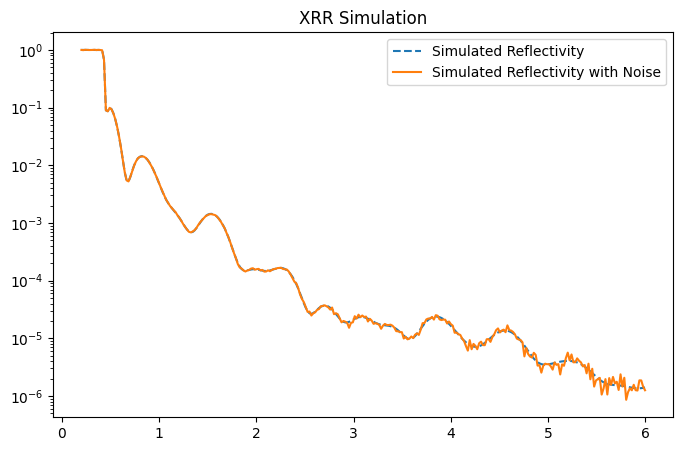

In [4]:
from itertools import combinations_with_replacement

# -----------------------
# 1. 데이터 생성
# -----------------------
beam_energy = 8.04751  # keV
tth = np.linspace(0.2, 6, 300)  # rad
q = tth2qz_by_energy(tth, beam_energy)

# 2층 박막 시뮬레이션 (기판 + 2개 필름)
thicknesses, roughnesses, slds = make_parameters(2)
structure = make_n_layer_structure(thicknesses, roughnesses, slds)
print(f"{thicknesses = }")
print(f"{roughnesses = }")
print(f"{slds = }")

real_thicks = thicknesses
real_thick_combs = [sum(set(comb)) for comb in combinations_with_replacement(real_thicks, r=len(real_thicks))]
print(f"{real_thick_combs = }")
R = structure_to_R(structure, q)
R_noise = R.copy()
R_noise = add_noise(R)

# Plot
fig, axs = plt.subplots(1, 1, figsize=(8, 5))

axs.semilogy(tth, R, "--", label="Simulated Reflectivity")
axs.semilogy(tth, R_noise, "-", label="Simulated Reflectivity with Noise")

axs.set_title("XRR Simulation")
axs.legend()
plt.show()

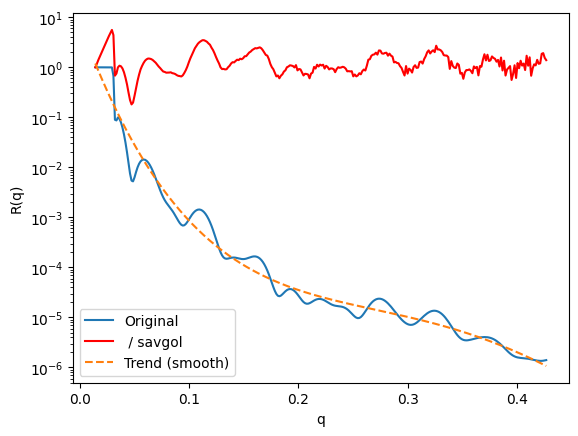

In [5]:
from scipy.signal import savgol_filter, find_peaks


def normalize_by_R(arr, R):
    if R.max() == 0:
        return arr
    return arr / arr[0] * R.max()

# 1. 부드러운 트렌드 생성
R_smooth = savgol_filter(np.log10(R), window_length=int(len(R)), polyorder=4, mode='interp')
savgol = 10**R_smooth
R_savgol = R_noise / savgol
# 2. 평탄화
R_savgol = normalize_by_R(R_savgol, R)
# 시각화
plt.figure()
plt.plot(q, R, label='Original')
plt.plot(q, R_savgol, label=' / savgol', color='red')
plt.plot(q, savgol, label='Trend (smooth)', linestyle='--')
plt.xlabel('q')
plt.ylabel('R(q)')
plt.yscale('log')
plt.legend()
plt.show()

[0.0294238  0.0363274  0.06256081 0.08327094 0.11364481 0.13159228
 0.13987552 0.14401709 0.14677812 0.16058298 0.16472435 0.1812894
 0.19233235 0.19785369 0.20061433 0.20613554 0.21441718 0.21717767
 0.21993814 0.22269859 0.22545901 0.22959959 0.23650043 0.24064085
 0.24616132 0.24892151 0.25168167 0.25582186 0.25996199 0.27100198
 0.27376191 0.28066158 0.28342139 0.28894091 0.29859976 0.30135936
 0.30687844 0.31239739 0.31929587 0.32343484 0.32619412 0.33998991
 0.34550796 0.34964639 0.35654358 0.36068176 0.36344051 0.36619921
 0.37033718 0.37309577 0.37723358 0.38275051 0.38550891 0.38826726
 0.39378384 0.39792115 0.4006793  0.40343741 0.40619547 0.40895348
 0.41171145 0.41584831 0.41860616 0.42412171]


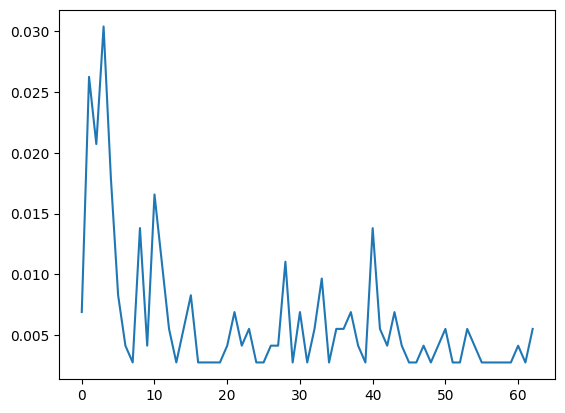

In [6]:
# TODO Equal q sampling


peaks, _ = find_peaks(R_savgol, prominence=1e-6)  # tune prominence
q_peaks = q[peaks]

dq = np.diff(q_peaks)
dq_mean = np.median(dq)
d_est = np.pi / dq_mean
print(q_peaks)
plt.plot(dq)
plt.show()

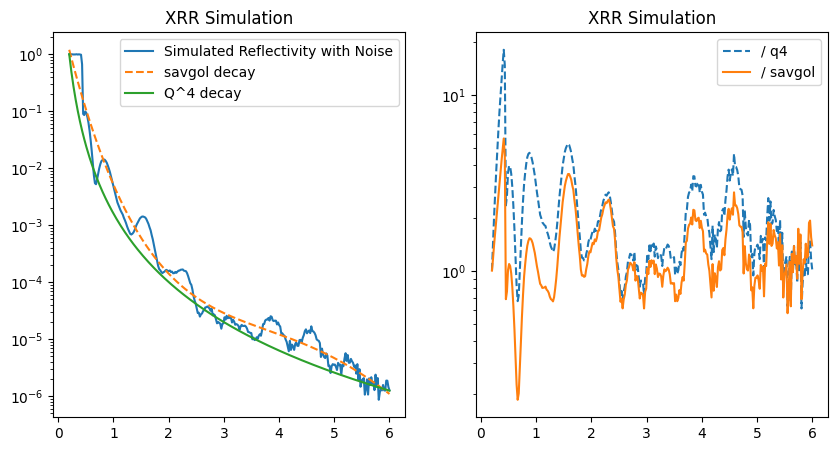

In [7]:
from scipy.signal import savgol_filter


def normalize_by_R(arr, R):
    if R.max() == 0:
        return arr
    return arr / arr[0] * R.max()

# 1. 부드러운 트렌드 생성
R_smooth = savgol_filter(np.log10(R_noise), window_length=int(len(R_noise)), polyorder=4, mode='interp')
savgol = 10**R_smooth

# 2. 평탄화
R_savgol = R_noise / savgol
R_q4 = remove_q4_decay(q, R_noise)
q4 = 1 / remove_q4_decay(q, np.full_like(q, 1))

R_savgol = normalize_by_R(R_savgol, R_noise)
R_q4 = normalize_by_R(R_q4, R_noise)
q4 = normalize_by_R(q4, R_noise)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].semilogy(tth, R_noise, "-", label="Simulated Reflectivity with Noise")
axs[0].semilogy(tth, savgol, "--", label="savgol decay")
axs[0].semilogy(tth, q4, "-", label="Q^4 decay")
axs[0].set_title("XRR Simulation")
axs[0].legend()

axs[1].semilogy(tth, R_q4, "--", label="/ q4")
axs[1].semilogy(tth, R_savgol, "-", label="/ savgol")
axs[1].set_title("XRR Simulation")
axs[1].legend()

plt.show()

In [ ]:
def nearest_index(array, value):
    """가장 가까운 인덱스 반환"""
    array = np.asarray(array)
    return np.argmin(np.abs(array - value))

Estimated critical q: 0.0000
x_fft[idx_real_thick_comb] = array([ 30.42287394, 115.60692097,  85.18404703])
x_fft[idx_local_max] = array([ 34.98630503,  82.14175963, 118.64920836])
x_under_bound=np.float64(24.338299150625105)


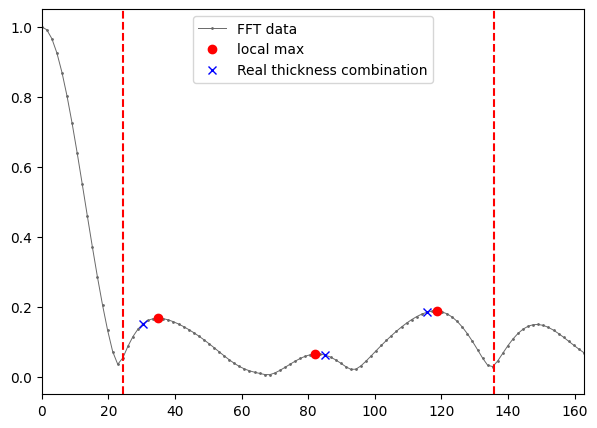

14.71887644660056


In [ ]:
from scipy.signal import argrelmax

# x_upper_bound = 200
x_upper_bound = sum(real_thicks) + 20
# crit_q = estimate_q(q, R_noise)
crit_q = 0
print(f"Estimated critical q: {crit_q:.4f}")

# FFT
# dat = np.stack([q, R_flat], axis=1)
# xproc, yproc = s_vector_transform_q(q, R_flat, crit_q)
x_fft, y_fft = xrr_fft(q, R_savgol, window=2, n=10000)
x_fft = x_fft * 2 * np.pi
y_fft_norm = y_fft / y_fft[0]

# Find Peaks
idx_local_max = argrelmax(y_fft_norm[x_fft < x_upper_bound])
local_max = y_fft_norm[x_fft < x_upper_bound][idx_local_max]
idx_real_thick_comb: list[int] = [nearest_index(x_fft, thickness) for thickness in real_thick_combs]
print(f"{x_fft[idx_real_thick_comb] = }")
print(f"{x_fft[idx_local_max] = }")


# First increasing index
y_diff = np.diff(y_fft_norm)
under_bound_index = np.where((y_diff >= -0.01) & (x_fft[1:] > 2))[0][0] + 1
# under_bound_index = np.abs(x_fft - crit_q * 2*np.pi).argmin()
x_under_bound = x_fft[under_bound_index]
print(f"{x_under_bound=}")
upper_bound_index = np.where(x_fft > x_upper_bound)[0][0]

fig, axs = plt.subplots(1, 1, sharex=True, figsize=(7, 5))
axs.plot(x_fft, y_fft_norm, "o-", ms=1, lw=0.7, color="dimgrey", label="FFT data")
axs.plot(x_fft[idx_local_max], y_fft_norm[idx_local_max], "o", color="red", label="local max")
axs.plot(x_fft[idx_real_thick_comb], y_fft_norm[idx_real_thick_comb], "x", color="b", label="Real thickness combination")
axs.axvline(x=x_fft[under_bound_index], color='r', linestyle='--')
axs.axvline(x=x_upper_bound, color='r', linestyle='--')
axs.set_xlim(0, x_upper_bound*1.2)

plt.legend()
plt.show()

print(2 * np.pi / q.max())

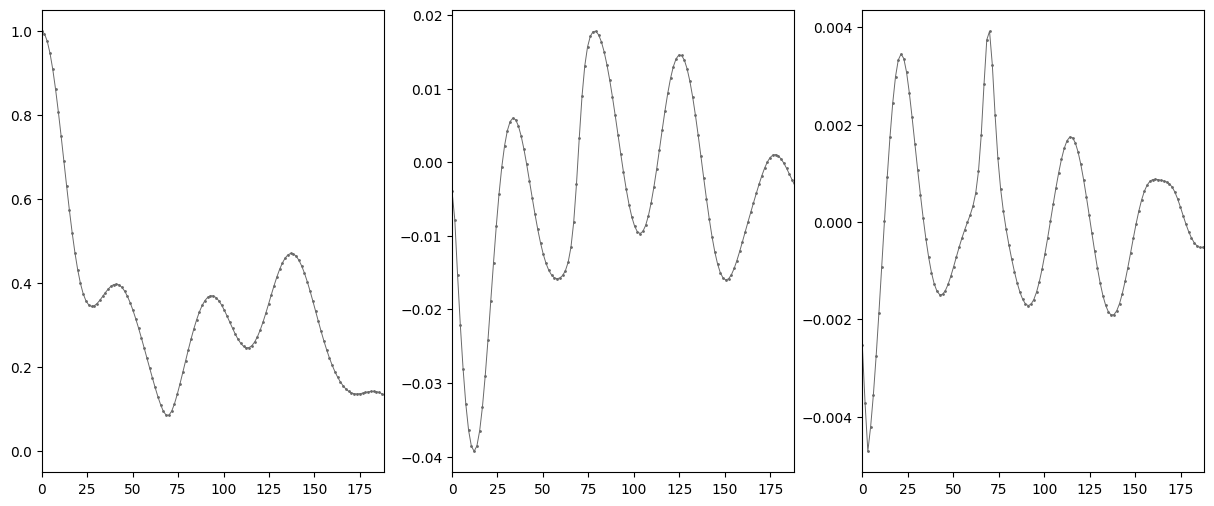

In [ ]:
dydx = np.gradient(y_fft_norm, x_fft)
# 2차 도함수 (곡률)
d2ydx2 = np.gradient(dydx, x_fft)

fig, axs = plt.subplots(1, 3, sharex=True, figsize=(15, 6))
axs[0].plot(x_fft, y_fft_norm, "o-", ms=1, lw=0.7, color="dimgrey", label="FFT data")
axs[1].plot(x_fft, dydx, "o-", ms=1, lw=0.7, color="dimgrey", label="FFT data")
axs[2].plot(x_fft, d2ydx2, "o-", ms=1, lw=0.7, color="dimgrey", label="FFT data")

for ax in axs:
    ax.set_xlim(0, x_upper_bound*1.2)

Top 2 estimated peak positions: 118.64920835929738 118.64920835929738
Initial guess:
[('a1', 0.1), ('w1', 5), ('a2', 0.1), ('pmax2', np.float64(118.64920835929738)), ('w2', 5), ('a3', 0.1), ('pmax3', np.float64(118.64920835929738)), ('w3', 5), ('amp', 1), ('ex', 2), ('z0', 0.001)]
>>> Multi-Gaussian fit results
- G1: amp=0.10, pos≈0.10 Å, w=6.79
- G2: amp=0.16, pos≈117.02 Å, w=21.69
- G3: amp=0.62, pos≈118.06 Å, w=0.04
- Noise: amp=4.83e+00, exp=1.06, offset=6.01e-19


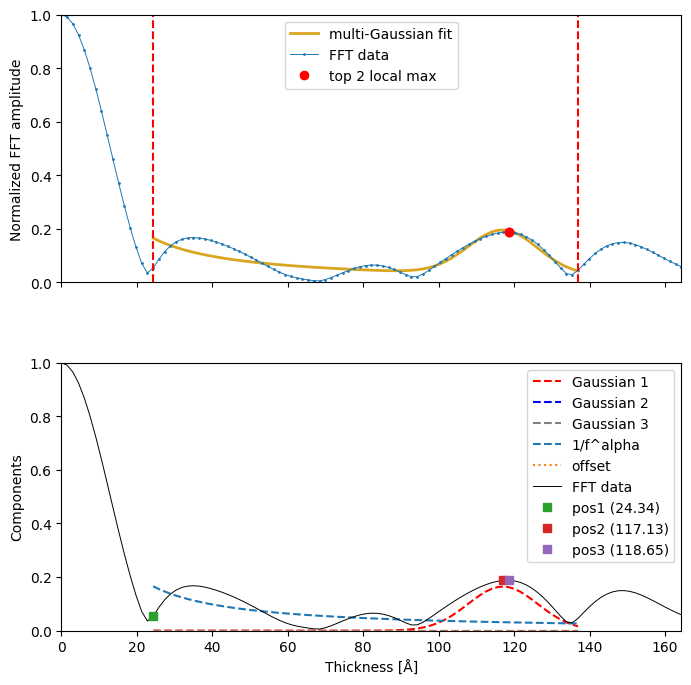

In [33]:
# ------------------------- 피팅 범위 설정 -------------------------
x_fit = x_fft[under_bound_index: upper_bound_index + 1]
y_fit = y_fft_norm[under_bound_index: upper_bound_index + 1]

# ------------------------- 로컬 최대값 기반 초기값 추정 -------------------------
# 모든 로컬 최대값을 그대로 사용
y_local = np.array([y_fit[nearest_index(y_fit, i)] for i in idx_local_max[0]])
x_local = np.array([x_fit[nearest_index(y_fit, i)] for i in idx_local_max[0]])

# 상위 2개 피크 위치만 추출
top2_indices = np.argsort(y_local)[-2:]
pmax2, pmax3 = x_local[top2_indices]
print("Top 2 estimated peak positions:", pmax2, pmax3)

# ------------------------- 초기값 설정 -------------------------
params = ["a1", "w1", "a2", "pmax2", "w2", "a3", "pmax3", "w3", "amp", "ex", "z0"]
p0 = [0.1, 5, 0.1, pmax2, 5, 0.1, pmax3, 5, 1, 2, 0.001]
print(f"Initial guess:\n{list(zip(params, p0, strict=True))}")

# ------------------------- 피팅 수행 -------------------------
popt, pcov = multi_gaussian_fitting(x_fit, y_fit, p0)

# 상대 위치 계산
pos2 = popt[3]
pos3 = popt[6]
pos1 = popt[0]

# ------------------------- 결과 출력 -------------------------
print(">>> Multi-Gaussian fit results")
print(f"- G1: amp={popt[0]:.2f}, pos≈{pos1:.2f} Å, w={popt[1]:.2f}")
print(f"- G2: amp={popt[2]:.2f}, pos≈{pos2:.2f} Å, w={popt[4]:.2f}")
print(f"- G3: amp={popt[5]:.2f}, pos≈{pos3:.2f} Å, w={popt[7]:.2f}")
print(f"- Noise: amp={popt[8]:.2e}, exp={popt[9]:.2f}, offset={popt[10]:.2e}")

# ------------------------- 시각화 -------------------------
fig, axs = plt.subplots(2, 1, sharex=True, figsize=(8, 8))

# 상단: 전체 fit vs 데이터
axs[0].plot(x_fit, func_gauss3_with_noise(x_fit, *popt), "-", color="goldenrod", lw=2, label="multi-Gaussian fit")
axs[0].plot(x_fft, y_fft_norm, "o-", ms=1, lw=0.7, label="FFT data")
axs[0].axvline(x=x_fft[under_bound_index], color='r', linestyle='--')
axs[0].axvline(x=x_fft[upper_bound_index], color='r', linestyle='--')
axs[0].plot(x_local[top2_indices], y_local[top2_indices], "o", color="red", label="top 2 local max")
axs[0].set_ylabel("Normalized FFT amplitude")
axs[0].legend()

# 하단: component 분리
axs[1].plot(x_fit, func_gauss(x_fit, *popt[2:5]), "--", color="red", label="Gaussian 1")
axs[1].plot(x_fit, func_gauss(x_fit, popt[0], pos1, popt[1]), "--", color="blue", label="Gaussian 2")
axs[1].plot(x_fit, func_gauss(x_fit, *popt[5:8]), "--", color="gray", label="Gaussian 3")
axs[1].plot(x_fit, func_noise(x_fit, *popt[8:10]), "--", label="1/f^alpha")
axs[1].plot(x_fit, np.ones_like(x_fit)*popt[10], ":", label="offset")
axs[1].plot(x_fft, y_fft_norm, "-", color='k', ms=1, lw=0.7, label="FFT data")

positions = [pos1, pos2, pos3]
idxs = [np.argmin(np.abs(x_fit - pos)) for pos in positions]
for i, idx in enumerate(idxs, start=1):
    axs[1].plot(x_fit[idx], y_fit[idx], "s", label=f"pos{i} ({x_fit[idx]:.2f})")

axs[1].set_xlabel("Thickness [Å]")
axs[1].set_ylabel("Components")
axs[1].legend()

axs[0].set_xlim(0, x_fft[upper_bound_index]*1.2)
axs[1].set_xlim(0, x_fft[upper_bound_index]*1.2)
axs[0].set_ylim(0, 1.0)
axs[1].set_ylim(0, 1.0)

fig.subplots_adjust(hspace=0.3)
plt.show()


24.338299150625105 136.9029327222662
118.64920835929738 118.64920835929738
Initial guess:
[('a1', 0.1), ('w1', 5), ('a2', 0.1), ('pmax2', np.float64(118.64920835929738)), ('w2', 5), ('a3', 0.1), ('pmax3', np.float64(118.64920835929738)), ('w3', 5), ('a4', 1), ('w4', 10), ('z0', 0.001)]
>>> Multi-Gaussian fit results
- G1: amp=0.14, pos≈13.32 Å, w=67.20
- G2: amp=0.09, pos≈107.01 Å, w=13.46
- G3: amp=0.16, pos≈120.33 Å, w=16.69
- Noise: amp=4.37e-02, exp=0.40, offset=2.33e-02


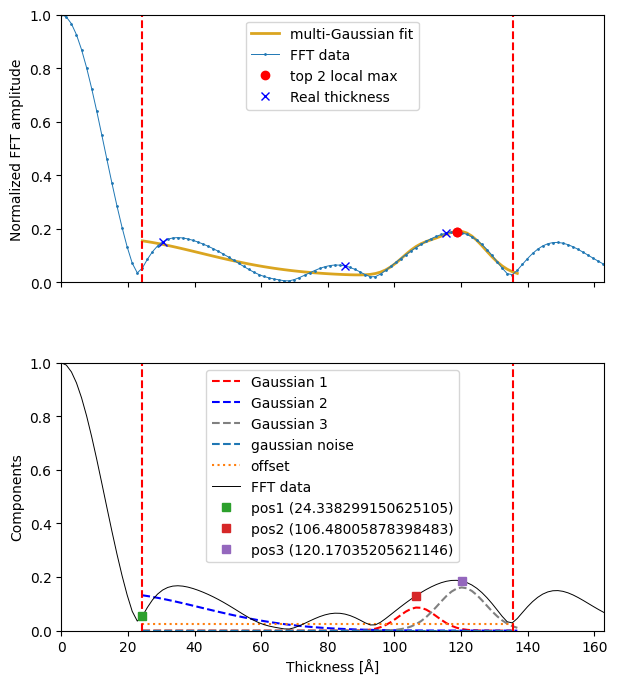

In [34]:
from reflectolearn.processing.fitting import (
    func_gauss3_with_noise_ver2,
    func_noise2,
)


def multi_gaussian_fitting2(x_fit, y_fit, p0):
    # ----------------------- Fit -----------------------
    bounds = (0, np.inf)
    popt, pcov = curve_fit(func_gauss3_with_noise_ver2, x_fit, y_fit, p0=p0, bounds=bounds)

    return popt, pcov

print(x_fft[under_bound_index], x_fft[upper_bound_index])

# fitting range

# ------------------------- 피팅 범위 설정 -------------------------
x_fit = x_fft[under_bound_index: upper_bound_index + 1]
y_fit = y_fft_norm[under_bound_index: upper_bound_index + 1]

# ------------------------- 로컬 최대값 기반 초기값 추정 -------------------------
# 모든 로컬 최대값을 그대로 사용
y_local = np.array([y_fit[nearest_index(y_fit, i)] for i in idx_local_max[0]])
x_local = np.array([x_fit[nearest_index(y_fit, i)] for i in idx_local_max[0]])


# 값이 큰 상위 2개 인덱스 추출
top2_indices = np.argsort(y_local)[-2:]          # 상위 2개 (y 값 기준)
top2_x = x_local[top2_indices]                   # 그 두 점의 x 위치

# 왼쪽/오른쪽 순서 정렬
top2_sorted = np.sort(top2_x)

# 결과 할당
if len(top2_sorted) == 1:
    top2_sorted = np.array([top2_sorted[0]]*2)
pmax2, pmax3 = top2_sorted[0], top2_sorted[1]
print(pmax2, pmax3)


params: list[str]= ["a1", "w1", "a2", "pmax2", "w2", "a3", "pmax3", "w3", "a4", "w4", "z0"]
p0: list[float] = [0.1, 5, 0.1, pmax2, 5, 0.1, pmax3, 5, 1, 10, 0.001]
print(f"Initial guess:\n{list(zip(params, p0, strict=True))}")
popt, pcov = multi_gaussian_fitting2(x_fit, y_fit, p0)

pos2 = popt[3]
pos3 = popt[6]
pos1 = pos3-pos2

# ----------------------- Report -----------------------
print(">>> Multi-Gaussian fit results")
print(f"- G1: amp={popt[0]:.2f}, pos≈{pos1:.2f} Å, w={popt[1]:.2f}")
print(f"- G2: amp={popt[2]:.2f}, pos≈{pos2:.2f} Å, w={popt[4]:.2f}")
print(f"- G3: amp={popt[5]:.2f}, pos≈{pos3:.2f} Å, w={popt[7]:.2f}")
print(f"- Noise: amp={popt[8]:.2e}, exp={popt[9]:.2f}, offset={popt[10]:.2e}")

# ----------------------- Plot -----------------------
fig, axs = plt.subplots(2, 1, sharex=True, figsize=(7, 8))

# (상단: 전체 fit vs 데이터)
axs[0].plot(x_fit, func_gauss3_with_noise_ver2(x_fit, *popt), "-", color="goldenrod", lw=2, label="multi-Gaussian fit")
axs[0].plot(x_fft, y_fft_norm, "o-", ms=1, lw=0.7, label="FFT data")
axs[0].axvline(x=x_under_bound, color='r', linestyle='--')
axs[0].axvline(x=x_upper_bound, color='r', linestyle='--')
axs[0].plot(x_local[top2_indices], y_local[top2_indices]  , "o", color="red", label="top 2 local max")
axs[0].plot(x_fft[idx_real_thick_comb], y_fft_norm[idx_real_thick_comb], "x", color="b", label="Real thickness")
axs[0].set_ylabel("Normalized FFT amplitude")
axs[0].legend()

# (하단: component 분리 보기)
axs[1].plot(x_fit, func_gauss(x_fit, *popt[2:5]), "--", color="red", label="Gaussian 1")
axs[1].plot(x_fit, func_gauss(x_fit, popt[0], popt[6] - popt[3], popt[1]), "--", color="blue", label="Gaussian 2")
axs[1].plot(x_fit, func_gauss(x_fit, *popt[5:8]), "--", color="gray", label="Gaussian 3")
axs[1].plot(x_fit, func_noise2(x_fit, *popt[8:10]), "--", label="gaussian noise")
axs[1].plot(x_fit, np.ones_like(x_fit)*popt[10], ":", label="offset")
axs[1].plot(x_fft, y_fft_norm, "-", color='k', ms=1, lw=0.7, label="FFT data")
axs[1].axvline(x=x_under_bound, color='r', linestyle='--')
axs[1].axvline(x=x_upper_bound, color='r', linestyle='--')
positions = [pos1, pos2, pos3]
idxs = [np.argmin(np.abs(x_fit - pos)) for pos in positions]
for i, idx in enumerate(idxs, start=1):
    axs[1].plot(x_fit[idx], y_fit[idx], "s", label=f"pos{i} ({x_fit[idx]})")

axs[1].set_xlabel("Thickness [Å]")
axs[1].set_ylabel("Components")
axs[1].legend()

axs[0].set_xlim(0, x_upper_bound*1.2)
axs[1].set_xlim(0, x_upper_bound*1.2)
axs[0].set_ylim(0, 1.0)
axs[1].set_ylim(0, 1.0)

fig.subplots_adjust(hspace=0.3)
plt.show()

In [ ]:
sorted_real_thicks = sorted(real_thicks)

print(*sorted_real_thicks, sep=", ")
poses = [pos1, pos2, pos3]
poses.sort()
print(*poses[:-1], sep=", ")
print(poses[0] + poses[1], poses[2], sorted_real_thicks[0] + sorted_real_thicks[1])

69.81434552433038, 83.44237905684716
56.08540147863309, 94.04830392135415
150.13370539998724 150.13370539998724 153.25672458117754
